# microexpression classification

# read data

In [1]:
import pandas as pd
import numpy as np

In [2]:
data_path = "DATA/microexpression/fer2013.csv"
df = pd.read_csv(data_path)

In [3]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
df['pixels'] = df['pixels'].str.split(' ').apply(lambda x: np.array([np.uint8(i) for i in x]).reshape(48,48))

In [5]:
df.head()

,emotion,pixels,Usage
0,0,"[[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, ...",Training
1,0,"[[151, 150, 147, 155, 148, 133, 111, 140, 170,...",Training
2,2,"[[231, 212, 156, 164, 174, 138, 161, 173, 182,...",Training
3,4,"[[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, ...",Training
4,6,"[[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 2...",Training


# divide dataset to train, val, test

In [6]:
# 记得把原来的index重设，否则val、test的dataframe序号不连续，否则后面y_val转成torch.LongTensor时会报错
def devide_x_y(my_df):
    return my_df['pixels'].reset_index(drop=True), my_df['emotion'].reset_index(drop=True)

In [7]:
# 分别筛选出training、publictest、privatetest对应的行
training = df['Usage']=="Training"
publicTest = df['Usage'] == "PublicTest"
privateTest = df["Usage"] == "PrivateTest"

# 读取对应行的数据
train = df[training]
public_t = df[publicTest]
private_t = df[privateTest]

# 分为 X 和 y
train_x, train_y = devide_x_y(train)
val_x, val_y = devide_x_y(public_t)
test_x, test_y = devide_x_y(private_t)

In [8]:
len(train_x), len(train_y), len(val_x), len(val_y), len(test_x), len(test_y)

(28709, 28709, 3589, 3589, 3589, 3589)

画一个图出来看一下

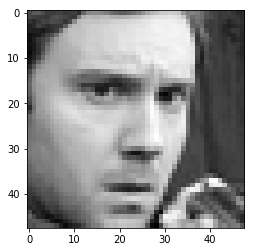

In [10]:
import matplotlib.pyplot as plt

img_test = train_x[0]
plt.figure()
plt.imshow(img_test,cmap='gray')
plt.show()

# make dataset

In [11]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

class MicroExpreDataset(Dataset):
    def __init__(self, x, y=None, transform=None):
        self.x = x
        self.y = y
        if y is not None:
            # label needs to be a LongTensor
            self.y = torch.LongTensor(y)
        self.transform = transform
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        X = self.x[index]
        if self.transform is not None:
            X = self.transform(X)
        if self.y is not None:
            Y = self.y[index]
            return X, Y
        else: return X

In [12]:
batch_size = 128
train_set = MicroExpreDataset(train_x, train_y, train_transform)
val_set = MicroExpreDataset(val_x, val_y, test_transform)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

# Model

In [13]:
import torch.nn as nn

class Classifier(nn.Module):
    def __init__(self):
        # super继承父类
        super(Classifier, self).__init__()
        
        # conv2d( in_channels, out_channels, kernel_size, stide, padding)
        # input shape: [1, 48, 48]
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 2, 1, 1), # [64, 49, 49]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0), #[64, 25, 25]
            
            nn.Conv2d(64, 128, 2, 1, 1), # [128, 26, 26]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2,0), # [128, 13, 13]
            
            nn.Conv2d(128, 256, 3, 1, 1), # [256, 13, 13]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0), # [256, 7, 7]
            
            nn.Conv2d(256, 256, 3, 1, 1), #[256, 7, 7]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0), #[256, 4, 4]        
        )
        
        self.fc = nn.Sequential(
            nn.Linear(2304, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.Linear(256, 7)
        )
        
    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

# Training

In [14]:
torch.cuda.get_device_name(0)

/home/zhouzy/softwares/Python-3.7.3/install/lib/python3.7/site-packages/torch/cuda/__init__.py:87: UserWarning: 
    Found GPU1 Quadro K600 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


'TITAN RTX'

训练30步

In [15]:
import os
import time

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
model = Classifier().cuda()

# classification task, so use crossEntropyLoss
loss = nn.CrossEntropyLoss()
# optimizer use Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epoch = 30

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0
    
    # open train mode
    model.train()
    for i, data in enumerate(train_loader):
        # set gradient to zero, otherwise it will be added each time
        optimizer.zero_grad()
        
        # train model to get the predict possibility. Actually, it is to call the forward function
        train_pred = model(data[0].cuda()) # data[0] is x
        batch_loss = loss(train_pred, data[1].cuda()) # data[1] is y
        
        # use backward to calculate the gradient for each parameter
        batch_loss.backward()
        # update the parameters by optimizer
        optimizer.step()
        
        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss.item()
        
    # turn model to eval mode
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            val_pred = model(data[0].cuda())
            batch_loss = loss(val_pred, data[1].cuda())
            
            val_acc += np.sum(np.argmax(val_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
            val_loss += batch_loss.item()
        
        # print out the results
        print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f' % \
            (epoch + 1, num_epoch, time.time()-epoch_start_time, \
             train_acc/train_set.__len__(), train_loss/train_set.__len__(), val_acc/val_set.__len__(), val_loss/val_set.__len__()))
        

[001/030] 12.03 sec(s) Train Acc: 0.328573 Loss: 0.013148 | Val Acc: 0.426024 loss: 0.012188
[002/030] 11.78 sec(s) Train Acc: 0.478143 Loss: 0.010555 | Val Acc: 0.488994 loss: 0.010460
[003/030] 11.24 sec(s) Train Acc: 0.533979 Loss: 0.009564 | Val Acc: 0.525216 loss: 0.009936
[004/030] 11.79 sec(s) Train Acc: 0.563482 Loss: 0.008975 | Val Acc: 0.561159 loss: 0.009435
[005/030] 11.62 sec(s) Train Acc: 0.585322 Loss: 0.008572 | Val Acc: 0.577320 loss: 0.009204
[006/030] 11.28 sec(s) Train Acc: 0.606569 Loss: 0.008150 | Val Acc: 0.577041 loss: 0.008942
[007/030] 11.50 sec(s) Train Acc: 0.618761 Loss: 0.007891 | Val Acc: 0.588465 loss: 0.008672
[008/030] 11.54 sec(s) Train Acc: 0.639347 Loss: 0.007554 | Val Acc: 0.567846 loss: 0.009275
[009/030] 11.66 sec(s) Train Acc: 0.655509 Loss: 0.007229 | Val Acc: 0.580942 loss: 0.008921
[010/030] 11.94 sec(s) Train Acc: 0.668083 Loss: 0.006954 | Val Acc: 0.604068 loss: 0.008808
[011/030] 12.46 sec(s) Train Acc: 0.685012 Loss: 0.006616 | Val Acc: 0

显示模型参数结构，前面算FC时，尺寸和我推算的不一致

打印后可知，原来是maxpool的时候并没有补数

In [16]:
def show_summary(my_model, my_input_size):
    from collections import OrderedDict
    import pandas as pd
    import numpy as np

    import torch
    from torch.autograd import Variable
    import torch.nn.functional as F
    from torch import nn


    def get_names_dict(model):
        """
        Recursive walk to get names including path
        """
        names = {}
        def _get_names(module, parent_name=''):
            for key, module in module.named_children():
                name = parent_name + '.' + key if parent_name else key
                names[name]=module
                if isinstance(module, torch.nn.Module):
                    _get_names(module, parent_name=name)
        _get_names(model)
        return names


    def torch_summarize_df(input_size, model, weights=False, input_shape=True, nb_trainable=False):
        """
        Summarizes torch model by showing trainable parameters and weights.
        
        author: wassname
        url: https://gist.github.com/wassname/0fb8f95e4272e6bdd27bd7df386716b7
        license: MIT
        
        Modified from:
        - https://github.com/pytorch/pytorch/issues/2001#issuecomment-313735757
        - https://gist.github.com/wassname/0fb8f95e4272e6bdd27bd7df386716b7/
        
        Usage:
            import torchvision.models as models
            model = models.alexnet()
            df = torch_summarize_df(input_size=(3, 224,224), model=model)
            print(df)
            
            #              name class_name        input_shape       output_shape  nb_params
            # 1     features=>0     Conv2d  (-1, 3, 224, 224)   (-1, 64, 55, 55)      23296#(3*11*11+1)*64
            # 2     features=>1       ReLU   (-1, 64, 55, 55)   (-1, 64, 55, 55)          0
            # ...
        """

        def register_hook(module):
            def hook(module, input, output):
                name = ''
                for key, item in names.items():
                    if item == module:
                        name = key
                #<class 'torch.nn.modules.conv.Conv2d'>
                class_name = str(module.__class__).split('.')[-1].split("'")[0]
                module_idx = len(summary)

                m_key = module_idx + 1

                summary[m_key] = OrderedDict()
                summary[m_key]['name'] = name
                summary[m_key]['class_name'] = class_name
                if input_shape:
                    summary[m_key][
                        'input_shape'] = (-1, ) + tuple(input[0].size())[1:]
                summary[m_key]['output_shape'] = (-1, ) + tuple(output.size())[1:]
                if weights:
                    summary[m_key]['weights'] = list(
                        [tuple(p.size()) for p in module.parameters()])

    #             summary[m_key]['trainable'] = any([p.requires_grad for p in module.parameters()])
                if nb_trainable:
                    params_trainable = sum([torch.LongTensor(list(p.size())).prod() for p in module.parameters() if p.requires_grad])
                    summary[m_key]['nb_trainable'] = params_trainable
                params = sum([torch.LongTensor(list(p.size())).prod() for p in module.parameters()])
                summary[m_key]['nb_params'] = params
                

            if  not isinstance(module, nn.Sequential) and \
                not isinstance(module, nn.ModuleList) and \
                not (module == model):
                hooks.append(module.register_forward_hook(hook))
                
        # Names are stored in parent and path+name is unique not the name
        names = get_names_dict(model)

        # check if there are multiple inputs to the network
        if isinstance(input_size[0], (list, tuple)):
            x = [Variable(torch.rand(1, *in_size)) for in_size in input_size]
        else:
            x = Variable(torch.rand(1, *input_size))

        if next(model.parameters()).is_cuda:
            x = x.cuda()

        # create properties
        summary = OrderedDict()
        hooks = []

        # register hook
        model.apply(register_hook)

        # make a forward pass
        model(x)

        # remove these hooks
        for h in hooks:
            h.remove()

        # make dataframe
        df_summary = pd.DataFrame.from_dict(summary, orient='index')

        return df_summary


    # Test on alexnet
    import torchvision.models as models
    df = torch_summarize_df(input_size=my_input_size, model=my_model)
    print(df)

In [17]:
show_summary(model, (1,48,48))

      name   class_name        input_shape       output_shape        nb_params
1    cnn.0       Conv2d    (-1, 1, 48, 48)   (-1, 64, 49, 49)      tensor(320)
2    cnn.1  BatchNorm2d   (-1, 64, 49, 49)   (-1, 64, 49, 49)      tensor(128)
3    cnn.2         ReLU   (-1, 64, 49, 49)   (-1, 64, 49, 49)                0
4    cnn.3    MaxPool2d   (-1, 64, 49, 49)   (-1, 64, 24, 24)                0
5    cnn.4       Conv2d   (-1, 64, 24, 24)  (-1, 128, 25, 25)    tensor(32896)
6    cnn.5  BatchNorm2d  (-1, 128, 25, 25)  (-1, 128, 25, 25)      tensor(256)
7    cnn.6         ReLU  (-1, 128, 25, 25)  (-1, 128, 25, 25)                0
8    cnn.7    MaxPool2d  (-1, 128, 25, 25)  (-1, 128, 12, 12)                0
9    cnn.8       Conv2d  (-1, 128, 12, 12)  (-1, 256, 12, 12)   tensor(295168)
10   cnn.9  BatchNorm2d  (-1, 256, 12, 12)  (-1, 256, 12, 12)      tensor(512)
11  cnn.10         ReLU  (-1, 256, 12, 12)  (-1, 256, 12, 12)                0
12  cnn.11    MaxPool2d  (-1, 256, 12, 12)    (-1, 2

# 调优测试

把train的过程写到函数里，方便后面反复调用

In [45]:
def train_test(my_model):
    os.environ["CUDA_VISIBLE_DEVICES"] = '0'
    model = my_model.cuda()

    # classification task, so use crossEntropyLoss
    loss = nn.CrossEntropyLoss()
    # optimizer use Adam
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    num_epoch = 30

    for epoch in range(num_epoch):
        epoch_start_time = time.time()
        train_acc = 0.0
        train_loss = 0.0
        val_acc = 0.0
        val_loss = 0.0

        # open train mode
        model.train()
        for i, data in enumerate(train_loader):
            # set gradient to zero, otherwise it will be added each time
            optimizer.zero_grad()

            # train model to get the predict possibility. Actually, it is to call the forward function
            train_pred = model(data[0].cuda()) # data[0] is x
            batch_loss = loss(train_pred, data[1].cuda()) # data[1] is y

            # use backward to calculate the gradient for each parameter
            batch_loss.backward()
            # update the parameters by optimizer
            optimizer.step()

            train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
            train_loss += batch_loss.item()

        # turn model to eval mode
        model.eval()
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                val_pred = model(data[0].cuda())
                batch_loss = loss(val_pred, data[1].cuda())

                val_acc += np.sum(np.argmax(val_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
                val_loss += batch_loss.item()

            # print out the results
            print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f' % \
                (epoch + 1, num_epoch, time.time()-epoch_start_time, \
                 train_acc/train_set.__len__(), train_loss/train_set.__len__(), val_acc/val_set.__len__(), val_loss/val_set.__len__()))
        

在模型中加上dropout

可以看到过拟合没有那么严重了，但val的acc还是没有提升上来

In [24]:
import torch.nn as nn

class Classifier_1(nn.Module):
    def __init__(self):
        # super继承父类
        super(Classifier_1, self).__init__()
        
        # conv2d( in_channels, out_channels, kernel_size, stide, padding)
        # input shape: [1, 48, 48]
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 2, 1, 1), # [64, 49, 49]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0), #[64, 25, 25]
            
            nn.Conv2d(64, 128, 2, 1, 1), # [128, 26, 26]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2,0), # [128, 13, 13]
            
            nn.Conv2d(128, 256, 3, 1, 1), # [256, 13, 13]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0), # [256, 7, 7]
            
            nn.Conv2d(256, 256, 3, 1, 1), #[256, 7, 7]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0), #[256, 4, 4]        
        )
        
        self.fc = nn.Sequential(
            nn.Linear(2304, 512),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.Dropout(0.3),
            nn.Linear(256, 7)
        )
        
    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

In [46]:
model_1 = Classifier_1()
train_test(model_1)

[001/300] 11.84 sec(s) Train Acc: 0.307012 Loss: 0.013331 | Val Acc: 0.390917 loss: 0.012439
[002/300] 11.64 sec(s) Train Acc: 0.446341 Loss: 0.011215 | Val Acc: 0.477292 loss: 0.010708
[003/300] 10.34 sec(s) Train Acc: 0.487896 Loss: 0.010351 | Val Acc: 0.510170 loss: 0.010196
[004/300] 10.30 sec(s) Train Acc: 0.520464 Loss: 0.009827 | Val Acc: 0.496517 loss: 0.010735
[005/300] 10.31 sec(s) Train Acc: 0.537671 Loss: 0.009498 | Val Acc: 0.557258 loss: 0.009401
[006/300] 10.30 sec(s) Train Acc: 0.553764 Loss: 0.009146 | Val Acc: 0.548064 loss: 0.009361
[007/300] 10.27 sec(s) Train Acc: 0.573653 Loss: 0.008861 | Val Acc: 0.579827 loss: 0.009006
[008/300] 10.24 sec(s) Train Acc: 0.587203 Loss: 0.008614 | Val Acc: 0.566174 loss: 0.009235
[009/300] 10.30 sec(s) Train Acc: 0.600300 Loss: 0.008362 | Val Acc: 0.551964 loss: 0.009816
[010/300] 10.37 sec(s) Train Acc: 0.613745 Loss: 0.008110 | Val Acc: 0.579549 loss: 0.008896
[011/300] 10.35 sec(s) Train Acc: 0.620851 Loss: 0.007870 | Val Acc: 0

[090/300] 10.37 sec(s) Train Acc: 0.941412 Loss: 0.001364 | Val Acc: 0.612705 loss: 0.020264
[091/300] 11.53 sec(s) Train Acc: 0.944547 Loss: 0.001277 | Val Acc: 0.624687 loss: 0.020585
[092/300] 10.32 sec(s) Train Acc: 0.944547 Loss: 0.001287 | Val Acc: 0.610198 loss: 0.019899
[093/300] 10.32 sec(s) Train Acc: 0.945731 Loss: 0.001268 | Val Acc: 0.625522 loss: 0.022411
[094/300] 10.33 sec(s) Train Acc: 0.942527 Loss: 0.001354 | Val Acc: 0.622179 loss: 0.020003
[095/300] 10.33 sec(s) Train Acc: 0.946010 Loss: 0.001275 | Val Acc: 0.619671 loss: 0.020668
[096/300] 10.39 sec(s) Train Acc: 0.944965 Loss: 0.001281 | Val Acc: 0.616049 loss: 0.021572
[097/300] 10.33 sec(s) Train Acc: 0.946428 Loss: 0.001259 | Val Acc: 0.619950 loss: 0.019856
[098/300] 11.55 sec(s) Train Acc: 0.947055 Loss: 0.001257 | Val Acc: 0.613820 loss: 0.020347
[099/300] 11.54 sec(s) Train Acc: 0.945766 Loss: 0.001240 | Val Acc: 0.619671 loss: 0.021763
[100/300] 10.25 sec(s) Train Acc: 0.951200 Loss: 0.001168 | Val Acc: 0

[179/300] 10.27 sec(s) Train Acc: 0.968024 Loss: 0.000761 | Val Acc: 0.623572 loss: 0.023480
[180/300] 10.27 sec(s) Train Acc: 0.968163 Loss: 0.000755 | Val Acc: 0.622736 loss: 0.022417
[181/300] 10.28 sec(s) Train Acc: 0.971124 Loss: 0.000696 | Val Acc: 0.627473 loss: 0.025452
[182/300] 10.29 sec(s) Train Acc: 0.970636 Loss: 0.000720 | Val Acc: 0.626916 loss: 0.026923
[183/300] 11.30 sec(s) Train Acc: 0.968721 Loss: 0.000761 | Val Acc: 0.621064 loss: 0.025070
[184/300] 10.35 sec(s) Train Acc: 0.968372 Loss: 0.000746 | Val Acc: 0.620228 loss: 0.024484
[185/300] 10.35 sec(s) Train Acc: 0.970845 Loss: 0.000703 | Val Acc: 0.625801 loss: 0.024766
[186/300] 10.35 sec(s) Train Acc: 0.969626 Loss: 0.000730 | Val Acc: 0.615213 loss: 0.023614
[187/300] 11.49 sec(s) Train Acc: 0.969348 Loss: 0.000749 | Val Acc: 0.625244 loss: 0.023003
[188/300] 10.36 sec(s) Train Acc: 0.967327 Loss: 0.000768 | Val Acc: 0.610755 loss: 0.023887
[189/300] 11.74 sec(s) Train Acc: 0.969800 Loss: 0.000729 | Val Acc: 0

[268/300] 10.34 sec(s) Train Acc: 0.979693 Loss: 0.000489 | Val Acc: 0.631095 loss: 0.027649
[269/300] 10.37 sec(s) Train Acc: 0.979449 Loss: 0.000492 | Val Acc: 0.620786 loss: 0.031775
[270/300] 11.53 sec(s) Train Acc: 0.977707 Loss: 0.000541 | Val Acc: 0.623572 loss: 0.026113
[271/300] 10.34 sec(s) Train Acc: 0.979728 Loss: 0.000497 | Val Acc: 0.610755 loss: 0.028796
[272/300] 10.32 sec(s) Train Acc: 0.978474 Loss: 0.000538 | Val Acc: 0.615213 loss: 0.028914
[273/300] 10.32 sec(s) Train Acc: 0.979484 Loss: 0.000517 | Val Acc: 0.615492 loss: 0.027856
[274/300] 10.87 sec(s) Train Acc: 0.979867 Loss: 0.000508 | Val Acc: 0.614099 loss: 0.029038
[275/300] 10.30 sec(s) Train Acc: 0.978683 Loss: 0.000533 | Val Acc: 0.622458 loss: 0.028345
[276/300] 10.33 sec(s) Train Acc: 0.977882 Loss: 0.000550 | Val Acc: 0.620786 loss: 0.026346
[277/300] 10.31 sec(s) Train Acc: 0.979031 Loss: 0.000507 | Val Acc: 0.622736 loss: 0.027546
[278/300] 10.33 sec(s) Train Acc: 0.978926 Loss: 0.000512 | Val Acc: 0

试一下，扩大图像。因为一开始图像的size有点小，图也比较模糊，可能特征没抓取好

In [36]:
import torch.nn as nn

class Classifier_2(nn.Module):
    def __init__(self):
        # super继承父类
        super(Classifier_2, self).__init__()
        
        # conv2d( in_channels, out_channels, kernel_size, stide, padding)
        # input shape: [1, 48, 48]
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 2, 1, 1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 1, 1), 
            
            nn.Conv2d(64, 128, 2, 1, 1), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2,0),
            
            nn.Conv2d(128, 256, 3, 1, 1), 
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0), 
            
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      
        )
        
        self.fc = nn.Sequential(
            nn.Linear(9216, 512),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.Dropout(0.3),
            nn.Linear(256, 7)
        )
        
    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

In [40]:
model_2 = Classifier_2()
show_summary(model_2, (1,48,48))

      name   class_name        input_shape       output_shape        nb_params
1    cnn.0       Conv2d    (-1, 1, 48, 48)   (-1, 64, 49, 49)      tensor(320)
2    cnn.1  BatchNorm2d   (-1, 64, 49, 49)   (-1, 64, 49, 49)      tensor(128)
3    cnn.2         ReLU   (-1, 64, 49, 49)   (-1, 64, 49, 49)                0
4    cnn.3    MaxPool2d   (-1, 64, 49, 49)   (-1, 64, 50, 50)                0
5    cnn.4       Conv2d   (-1, 64, 50, 50)  (-1, 128, 51, 51)    tensor(32896)
6    cnn.5  BatchNorm2d  (-1, 128, 51, 51)  (-1, 128, 51, 51)      tensor(256)
7    cnn.6         ReLU  (-1, 128, 51, 51)  (-1, 128, 51, 51)                0
8    cnn.7    MaxPool2d  (-1, 128, 51, 51)  (-1, 128, 25, 25)                0
9    cnn.8       Conv2d  (-1, 128, 25, 25)  (-1, 256, 25, 25)   tensor(295168)
10   cnn.9  BatchNorm2d  (-1, 256, 25, 25)  (-1, 256, 25, 25)      tensor(512)
11  cnn.10         ReLU  (-1, 256, 25, 25)  (-1, 256, 25, 25)                0
12  cnn.11    MaxPool2d  (-1, 256, 25, 25)  (-1, 256

In [44]:
train_test(model_2)

[001/030] 15.66 sec(s) Train Acc: 0.679717 Loss: 0.006690 | Val Acc: 0.605740 loss: 0.008994
[002/030] 14.25 sec(s) Train Acc: 0.691421 Loss: 0.006434 | Val Acc: 0.598217 loss: 0.009222
[003/030] 14.27 sec(s) Train Acc: 0.697900 Loss: 0.006361 | Val Acc: 0.612148 loss: 0.009737
[004/030] 14.26 sec(s) Train Acc: 0.696367 Loss: 0.006386 | Val Acc: 0.613820 loss: 0.009218
[005/030] 14.16 sec(s) Train Acc: 0.702045 Loss: 0.006217 | Val Acc: 0.616049 loss: 0.009458
[006/030] 14.29 sec(s) Train Acc: 0.709534 Loss: 0.006086 | Val Acc: 0.614935 loss: 0.009945
[007/030] 14.33 sec(s) Train Acc: 0.710265 Loss: 0.006052 | Val Acc: 0.617164 loss: 0.009822
[008/030] 14.32 sec(s) Train Acc: 0.718451 Loss: 0.005932 | Val Acc: 0.606297 loss: 0.010312
[009/030] 14.30 sec(s) Train Acc: 0.720088 Loss: 0.005839 | Val Acc: 0.614935 loss: 0.009941
[010/030] 14.32 sec(s) Train Acc: 0.731060 Loss: 0.005677 | Val Acc: 0.615492 loss: 0.009861
[011/030] 15.31 sec(s) Train Acc: 0.728657 Loss: 0.005714 | Val Acc: 0

## 寻找到较好的模型参数后，合并train，val一起训练

In [18]:
train_val_x = np.concatenate((train_x, val_x), axis=0)
train_val_y = np.concatenate((train_y, val_y), axis=0)
train_val_set = MicroExpreDataset(train_val_x, train_val_y, train_transform)
train_val_loader = DataLoader(train_val_set, batch_size=batch_size, shuffle=True)

In [19]:
model_best = Classifier().cuda()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_best.parameters(), lr=0.001)
num_epoch = 30

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0
    
    model_best.train()
    for i, data in enumerate(train_val_loader):
        optimizer.zero_grad()
        train_pred = model_best(data[0].cuda())
        batch_loss = loss(train_pred, data[1].cuda())
        batch_loss.backward()
        optimizer.step()
        
        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        train_loss+= batch_loss.item()
        
        # print out the result
    print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f' % \
      (epoch + 1, num_epoch, time.time()-epoch_start_time, \
      train_acc/train_val_set.__len__(), train_loss/train_val_set.__len__()))

[001/030] 11.49 sec(s) Train Acc: 0.343767 Loss: 0.012870
[002/030] 11.51 sec(s) Train Acc: 0.497090 Loss: 0.010235
[003/030] 11.68 sec(s) Train Acc: 0.541891 Loss: 0.009361
[004/030] 11.80 sec(s) Train Acc: 0.571274 Loss: 0.008760
[005/030] 11.57 sec(s) Train Acc: 0.592390 Loss: 0.008395
[006/030] 11.20 sec(s) Train Acc: 0.611400 Loss: 0.008077
[007/030] 11.24 sec(s) Train Acc: 0.628584 Loss: 0.007733
[008/030] 11.79 sec(s) Train Acc: 0.643260 Loss: 0.007445
[009/030] 11.60 sec(s) Train Acc: 0.659669 Loss: 0.007096
[010/030] 11.53 sec(s) Train Acc: 0.673695 Loss: 0.006792
[011/030] 11.61 sec(s) Train Acc: 0.687999 Loss: 0.006540
[012/030] 11.65 sec(s) Train Acc: 0.702551 Loss: 0.006268
[013/030] 11.60 sec(s) Train Acc: 0.718001 Loss: 0.005917
[014/030] 11.79 sec(s) Train Acc: 0.736795 Loss: 0.005612
[015/030] 12.30 sec(s) Train Acc: 0.750480 Loss: 0.005300
[016/030] 12.02 sec(s) Train Acc: 0.762029 Loss: 0.005118
[017/030] 11.64 sec(s) Train Acc: 0.776828 Loss: 0.004728
[018/030] 11.6

保存模型

In [53]:
torch.save(model_best, 'model_best.pkl')

## Test

In [54]:
# load model
test_model = torch.load('model_best.pkl')

In [66]:
test_set = MicroExpreDataset(test_x, test_y, test_transform)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [67]:
test_set.__len__()

3589

In [70]:
test_model.eval()
prediction = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        test_pred = test_model(data[0].cuda())
        test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        for y in test_label:
            prediction.append(y)

In [71]:
len(prediction)

3589

In [73]:
test_acc = np.sum(prediction == test_y) / test_set.__len__()
test_acc

0.6224575090554472

## save model

通过torch.save保存整个模型，读取时会有一些报错问题。官方建议只保存训练参数，所以这边再存一下

In [20]:
torch.save(model_best.state_dict(),'model_best_para.pkl')